## Feature engineering

El objetivo de este notebook es generar nuevas variables a partir de las analizadas. Tambíen se hará una breve exploración para determinar si son variables que pueden ser importantes para el modelo.

### Import de los paquetes

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Ignorar todas las advertencias
warnings.filterwarnings("ignore")


%matplotlib inline

### Configuraciones

In [2]:
pd.set_option("display.max_columns", None)

### Carga de datos

In [3]:
df = pd.read_csv("../data/intermediate/dataset_outliers_processed.csv")
df.shape

(3000, 15)

### Creacion de nuevas variables

In [4]:
# Creamos un campo auxiliar para poder calcular ratios luego
df["auxFactura"] = 1

#### Comportamiento del payer

El objetivo de estos features es aportar a la predicción comportamiento del payer en transacciones pasadas. El planteo es que payers que en general son deudores, tiene mayor posibilidad de ser morosos en el futuro.

In [5]:
# Ordenamos para poder generar features a partir de ventos pasados
df = df.sort_values(["payerId", "diasActividadPagador"]).copy()

In [6]:
# Agrupamos por payer y sumamos. Generamos variables auxiliares
df["payerNroFactMorosas"] = df.groupby("payerId")["facturaMorosa"].cumsum()
df["payerNroFacturas"] = df.groupby("payerId")["auxFactura"].cumsum()
df["payerAmountFacturas"] = df.groupby("payerId")["montoFacturaWsz"].cumsum()
df["payerDiasMora"] = df.groupby("payerId")["mora"].cumsum()

# Le restamos la factura actual
df["payerNroFactMorosas"] = df["payerNroFactMorosas"] - df["facturaMorosa"]
df["payerNroFacturas"] = df["payerNroFacturas"] - df["auxFactura"]
df["payerAmountFacturas"] = df["payerAmountFacturas"] - df["montoFacturaWsz"]
df["payerDiasMora"] = df["payerDiasMora"] - df["mora"]

# Calculamos las nuevas variables
df["payerRatioMorosidad"] = df["payerNroFactMorosas"] / df["payerNroFacturas"]
df["payerAvgAmountFacturas"] = df["payerAmountFacturas"] / df["payerNroFacturas"]
df["payerAvgDiasMora"] = df["payerDiasMora"] / df["payerNroFacturas"]

# Dado que el primer registro no tiene sumas acumuladas queda en nan e imputamos
df.fillna(0, inplace=True)

# Para mejor legilibilidad casteamos
df["payerAvgAmountFacturas"] = df["payerAvgAmountFacturas"].astype(int)

# Creamos otra veiable
df["payerDesvAmount"] = df["montoFacturaWsz"] - df["payerAvgAmountFacturas"]

**Notas:**

Si bien creamos un buen número de variables, algunos fueron creadas de forma auxiliar. El objetivo del paso anterior fue crear las siguientes variables:
- `payerRatioMorosidad`: ratio de facturas impagas.
- `payerAvgDiasMora`: promedio de días en cancelar las facturas.
- `payerDesvAmount`: cuanto se desvia en payer de sus gastos promedios.

In [7]:
df.loc[df["payerId"] == 5015].sort_values("diasActividadPagador").head(5)

,invoiceId,businessId,payerId,montoFactura,relationDays,relationRecurrence,issuerInvoicesAmount,issuerCancelledInvoices,diasActividadPagador,Clients12Months,mora,facturaMorosa,montoFacturaWsz,issuerInvoicesAmountWsz,Clients12MonthsWsz,auxFactura,payerNroFactMorosas,payerNroFacturas,payerAmountFacturas,payerDiasMora,payerRatioMorosidad,payerAvgAmountFacturas,payerAvgDiasMora,payerDesvAmount
2631,124,2729,5015,1823675,384.0,15.320000,31155691,0.056013,2416.0,3,14.0,1,1823675.0,31155691.0,3.0,1,0,0,0.0,0.0,0.000000,0,0.0,1823675.0
577,87,3132,5015,6784785,334.0,1.958824,651763252,0.050363,2420.0,742,7.0,1,6784785.0,651763252.0,161.1,1,1,1,1823675.0,14.0,1.000000,1823675,14.0,4961110.0
2659,516,1522,5015,1213800,1189.0,5.915423,214319000,0.016761,2429.0,20,-15.0,0,1213800.0,214319000.0,20.0,1,2,2,8608460.0,21.0,1.000000,4304230,10.5,-3090430.0
591,1022,1522,5015,1011500,1198.0,5.925743,234697750,0.017531,2438.0,20,-8.0,0,1011500.0,234697750.0,20.0,1,2,3,9822260.0,6.0,0.666667,3274086,2.0,-2262586.0
2794,379,701,5015,1385160,172.0,8.095238,210201112,0.124591,2438.0,18,-14.0,0,1385160.0,210201112.0,18.0,1,2,4,10833760.0,-2.0,0.500000,2708440,-0.5,-1323280.0


#### Comportamiento del business

El objetivo es similar a lo que hicimos anteriormente con el payer.

In [8]:
# Ordenamos para poder generar los calculos
df = df.sort_values(["businessId", "invoiceId"]).copy()

In [9]:
# Calcular la suma acumulativa de campo1 y campo2 por grupo
df["businessNroFactMorosas"] = df.groupby("businessId")["facturaMorosa"].cumsum()
df["businessNroFacturas"] = df.groupby("businessId")["auxFactura"].cumsum()
df["businessDiasMora"] = df.groupby("businessId")["mora"].cumsum()

# Restamos la factura actual
df["businessNroFactMorosas"] = df["businessNroFactMorosas"] - df["facturaMorosa"]
df["businessNroFacturas"] = df["businessNroFacturas"] - df["auxFactura"]
df["businessDiasMora"] = df["businessDiasMora"] - df["mora"]

# Calculamos las nuevas variables
df["businessRatioMororsidad"] = df["businessNroFactMorosas"] / df["businessNroFacturas"]
df["businessAvgDiasMora"] = df["businessDiasMora"] / df["businessNroFacturas"]

# Imputamos los nulls que quedaron luego de agrupar
df.fillna(0, inplace=True)

**Notas:**

Aplica para lo mismo que para las variables generadas para el payer. El resultado de lo realizado nos deja las siguientes variables:

- `businessRatioMororsidad`: ratio de facturas impagas. Este feature es diferente el ratio de facturas canceladas, dado que una factura que no esté cancelada no significa que se encuentre morosa, dado que la fecha de vencimiento se pudo no haber cumplicado.
- `businessAvgDiasMora`: promedio de días en cancelar las facturas.

In [10]:
df.loc[df["businessId"] == 3560].sort_values("invoiceId").head(10)

,invoiceId,businessId,payerId,montoFactura,relationDays,relationRecurrence,issuerInvoicesAmount,issuerCancelledInvoices,diasActividadPagador,Clients12Months,mora,facturaMorosa,montoFacturaWsz,issuerInvoicesAmountWsz,Clients12MonthsWsz,auxFactura,payerNroFactMorosas,payerNroFacturas,payerAmountFacturas,payerDiasMora,payerRatioMorosidad,payerAvgAmountFacturas,payerAvgDiasMora,payerDesvAmount,businessNroFactMorosas,businessNroFacturas,businessDiasMora,businessRatioMororsidad,businessAvgDiasMora
321,2182,3560,5015,16856207,322.0,6.254902,422006904,0.043667,2465.0,2,-19.0,0,16856207.0,422006904.0,2.0,1,3,10,33181972.0,-30.0,0.300000,3318197,-3.000000,13538010.0,0,0,0.0,0.000000,0.000000
540,2957,3560,5015,7073312,340.0,6.203704,465179985,0.041512,2483.0,2,-1.0,0,7073312.0,465179985.0,2.0,1,3,12,54054429.0,-63.0,0.250000,4504535,-5.250000,2568777.0,0,1,-19.0,0.000000,-19.000000
1785,4924,3560,5015,1349817,376.0,6.064516,571005639,0.038231,2519.0,2,28.0,1,1349817.0,571005639.0,2.0,1,4,18,71984540.0,-67.0,0.222222,3999141,-3.722222,-2649324.0,0,2,-20.0,0.000000,-10.000000
2134,8449,3560,5015,691414,435.0,6.041667,735087527,0.034095,2578.0,1,9.0,1,691414.0,735087527.0,1.0,1,10,32,130290055.0,16.0,0.312500,4071564,0.500000,-3380150.0,1,3,8.0,0.333333,2.666667
2795,8559,3560,5015,8265157,438.0,6.000000,743544821,0.033837,2581.0,1,0.0,0,8265157.0,743544821.0,1.0,1,11,33,130981469.0,25.0,0.333333,3969135,0.757576,4296022.0,2,4,17.0,0.500000,4.250000
1658,9604,3560,5015,608899,454.0,5.536585,789673114,0.035192,2597.0,1,13.0,1,608899.0,789673114.0,1.0,1,12,38,168366447.0,38.0,0.315789,4430695,1.000000,-3821796.0,2,5,17.0,0.400000,3.400000
1329,10248,3560,5015,397734,466.0,5.177778,829917238,0.034461,2609.0,1,14.0,1,397734.0,829917238.0,1.0,1,14,41,172779205.0,57.0,0.341463,4214126,1.390244,-3816392.0,3,6,30.0,0.500000,5.000000
1308,10619,3560,5015,453890,473.0,5.031915,853194639,0.033848,2616.0,1,7.0,1,453890.0,853194639.0,1.0,1,15,42,173176939.0,71.0,0.357143,4123260,1.690476,-3669370.0,4,7,44.0,0.571429,6.285714
2758,10800,3560,5015,3838571,475.0,4.947917,861452835,0.033573,2618.0,1,17.0,1,3838571.0,861452835.0,1.0,1,17,44,177770958.0,85.0,0.386364,4040249,1.931818,-201678.0,5,8,51.0,0.625000,6.375000
1101,13425,3560,5015,4641000,516.0,4.128000,978624470,0.030561,2659.0,1,0.0,0,4641000.0,978624470.0,1.0,1,22,50,204074057.0,152.0,0.440000,4081481,3.040000,559519.0,6,9,68.0,0.666667,7.555556


### Análisis de las variables generadas

##### Payer Ratio Morosidad

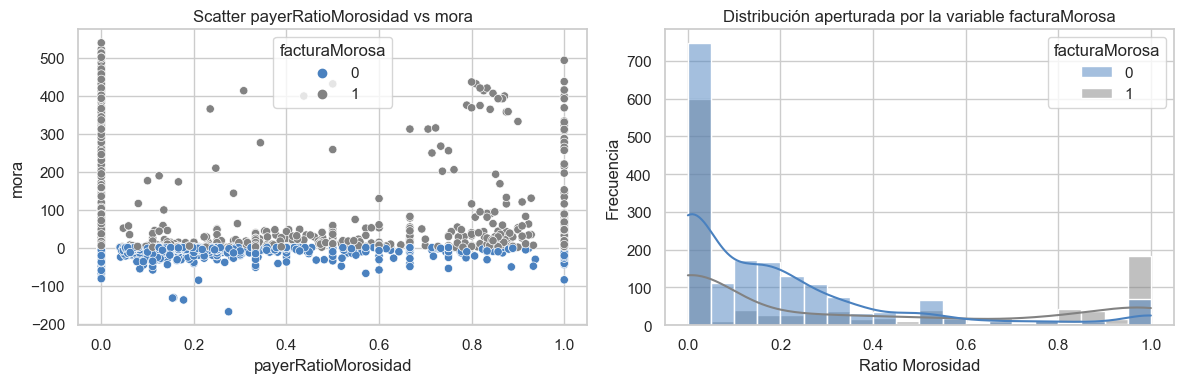

In [11]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# Scatter plot
sns.scatterplot(
    x="payerRatioMorosidad",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[0],
)
# Agregamos etiquetas y título
axes[0].set_title("Scatter payerRatioMorosidad vs mora")

# Hist plot
sns.histplot(
    df,
    x="payerRatioMorosidad",
    hue="facturaMorosa",
    bins=20,
    palette=["#4A81BF", "#828282"],
    kde=True,
)

# Agregamos etiquetas y título
axes[1].set_xlabel("payerRatioMorosidad")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución aperturada por la variable facturaMorosa")

# Ajustamos el diseño
plt.tight_layout()

# Mostramos los scatter plots
plt.show()


**Notas:**
Dado que existen muchos payers sin facturas, podemos observar muchos casos cuyo ratio es 0. En principio esto no es un incoveniente, dado que un arbol de decisión podría discriminar dicho comportamiento y podría trabajarlo sin problemas.

Podemos ver de todas forma que existe cierta relación entre el comportamiento histórico de los payers y su probabilidad de volver a ser morosos.

#### Payer Avg Dias Mora

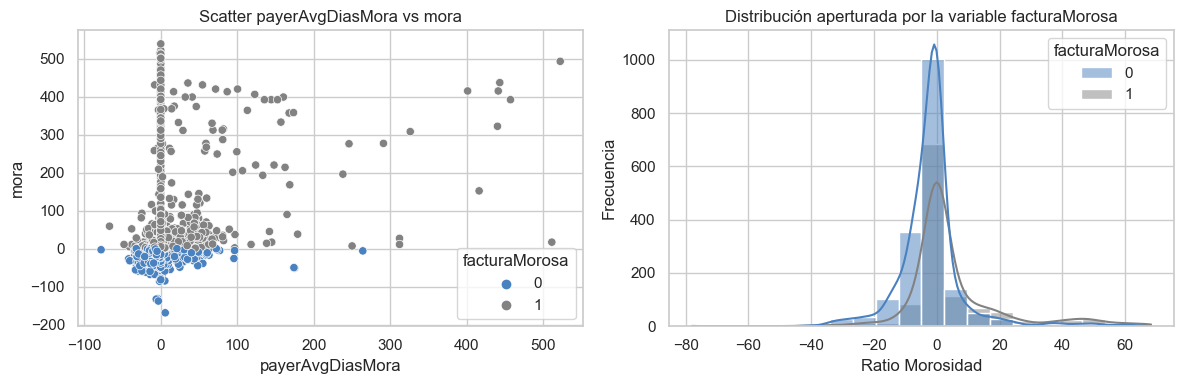

In [12]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# Scatter plot
sns.scatterplot(
    x="payerAvgDiasMora",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[0],
)
# Agregamos etiquetas y título
axes[0].set_title("Scatter payerAvgDiasMora vs mora")

# Hist plot
sns.histplot(
    df.loc[df["payerAvgDiasMora"] < 70],
    x="payerAvgDiasMora",
    hue="facturaMorosa",
    bins=20,
    palette=["#4A81BF", "#828282"],
    kde=True,
)

# Agregamos etiquetas y título
axes[1].set_xlabel("payerAvgDiasMora")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución aperturada por la variable facturaMorosa")

# Ajustamos el diseño
plt.tight_layout()

# Mostramos los scatter plots
plt.show()


**Notas:**
Si bien no es notable, podría verse levemente que los que suelen tener alto promedio en los días de mora son más propensos a reincidir.

#### Payer Desv Amount

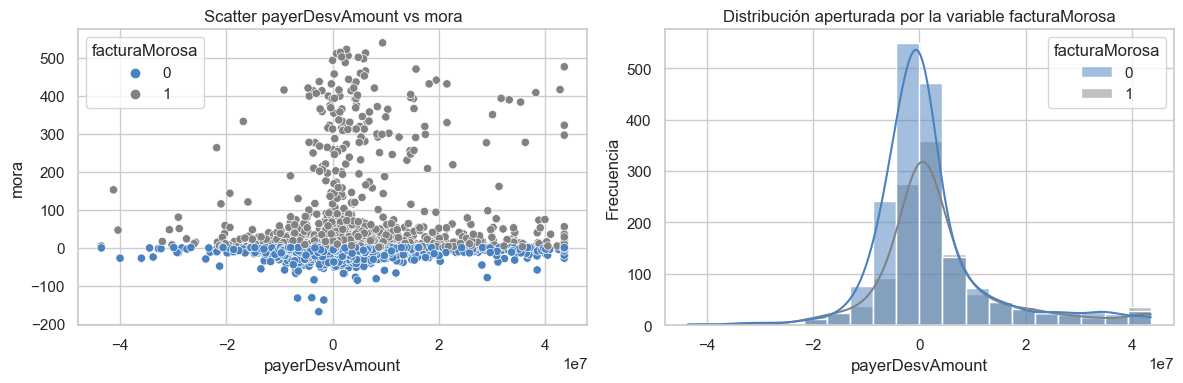

In [16]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# Scatter plot
sns.scatterplot(
    x="payerDesvAmount",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[0],
)
# Agregamos etiquetas y título
axes[0].set_title("Scatter payerDesvAmount vs mora")

# Hist plot
sns.histplot(
    df,
    x="payerDesvAmount",
    hue="facturaMorosa",
    bins=20,
    palette=["#4A81BF", "#828282"],
    kde=True,
)

# Agregamos etiquetas y título
axes[1].set_xlabel("payerDesvAmount")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución aperturada por la variable facturaMorosa")

# Ajustamos el diseño
plt.tight_layout()

# Mostramos los scatter plots
plt.show()


**Notas:**

No se suele ver alguna tendencia marcada. La idea era esperar que aquellos gastos mayores al promedios tengan más probabilidad de no ser pagos. Pero es muy leve lo que se visualiza en los gráficos.

#### Business Ratio Mororsidad

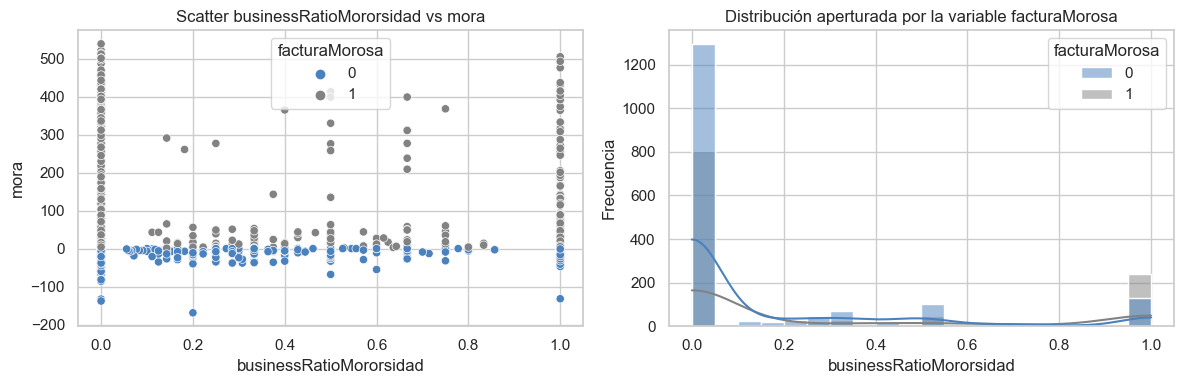

In [17]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# Scatter plot
sns.scatterplot(
    x="businessRatioMororsidad",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[0],
)
# Agregamos etiquetas y título
axes[0].set_title("Scatter businessRatioMororsidad vs mora")

# Hist plot
sns.histplot(
    df,
    x="businessRatioMororsidad",
    hue="facturaMorosa",
    bins=20,
    palette=["#4A81BF", "#828282"],
    kde=True,
)

# Agregamos etiquetas y título
axes[1].set_xlabel("businessRatioMororsidad")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución aperturada por la variable facturaMorosa")

# Ajustamos el diseño
plt.tight_layout()

# Mostramos los scatter plots
plt.show()


**Notas:**
Al parecer esta variable no va a tener ningún impacto en el modelo. La evaluaremos con otros métodos en el próximo paso.

#### Business Avg Dias Mora

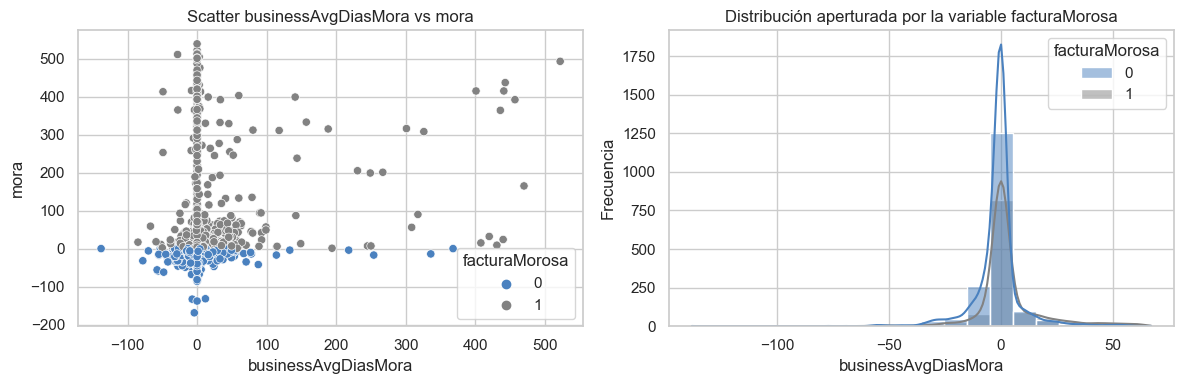

In [19]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# Scatter plot
sns.scatterplot(
    x="businessAvgDiasMora",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[0],
)
# Agregamos etiquetas y título
axes[0].set_title("Scatter businessAvgDiasMora vs mora")

# Hist plot
sns.histplot(
    df.loc[df["businessAvgDiasMora"] < 70],
    x="businessAvgDiasMora",
    hue="facturaMorosa",
    bins=20,
    palette=["#4A81BF", "#828282"],
    kde=True,
)

# Agregamos etiquetas y título
axes[1].set_xlabel("businessAvgDiasMora")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución aperturada por la variable facturaMorosa")

# Ajustamos el diseño
plt.tight_layout()

# Mostramos los scatter plots
plt.show()

**Notas:**
El comportamiento es muy parecido a la variable generada con los datos del payer.

### Guardado de datos

In [21]:
# Eliminamos la columna auxiliar que creamos en el principio
df.drop(columns=["auxFactura"], inplace=True)

In [22]:
df.to_csv("../data/intermediate/dataset_newfeatures_processed.csv", index_label=False)